# EDA - Fraud Data
This notebook explores the e-commerce transaction dataset.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure reports/figures directory exists
os.makedirs('../reports/figures', exist_ok=True)

# Load feature engineered data (includes country)
df = pd.read_csv('../data/processed/Fraud_Data_features.csv')
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_since_signup,hour_of_day,day_of_week,user_id_count,device_id_count
0,62421,2015-02-16 00:17:05,2015-03-08 10:00:39,46,ZCLZTAJPCRAQX,Direct,Safari,M,36,52093,0,Unknown,1763014.0,10,6,1,1
1,173212,2015-03-08 04:03:22,2015-03-20 17:23:45,33,YFGYOALADBHLT,Ads,IE,F,30,93447,0,Unknown,1084823.0,17,4,1,1
2,242286,2015-05-17 16:45:54,2015-05-26 08:54:34,33,QZNVQTUITFTHH,Direct,FireFox,F,32,105818,0,Unknown,749320.0,8,1,1,1
3,370003,2015-03-03 19:58:39,2015-05-28 21:09:13,33,PIBUQMBIELMMG,Ads,IE,M,40,117566,0,Unknown,7434634.0,21,3,1,1
4,119824,2015-03-20 00:31:27,2015-04-05 07:31:46,55,WFIIFCPIOGMHT,Ads,Safari,M,38,131423,0,Unknown,1407619.0,7,6,1,1


## Class Distribution

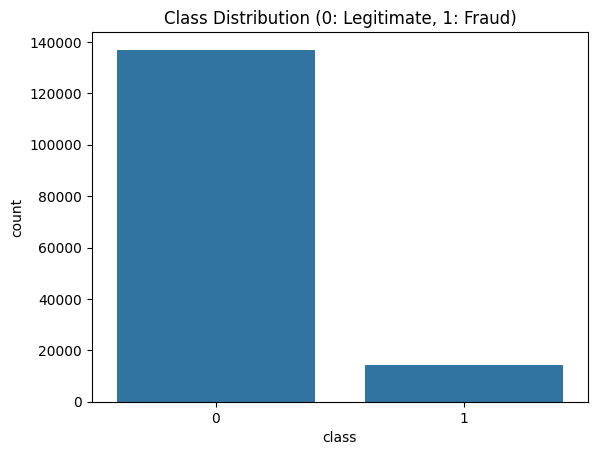

class
0    0.906354
1    0.093646
Name: proportion, dtype: float64


In [6]:
sns.countplot(x='class', data=df)
plt.title('Class Distribution (0: Legitimate, 1: Fraud)')
plt.savefig('../reports/figures/fraud_class_distribution.png')
plt.show()

print(df['class'].value_counts(normalize=True))

## Univariate Analysis

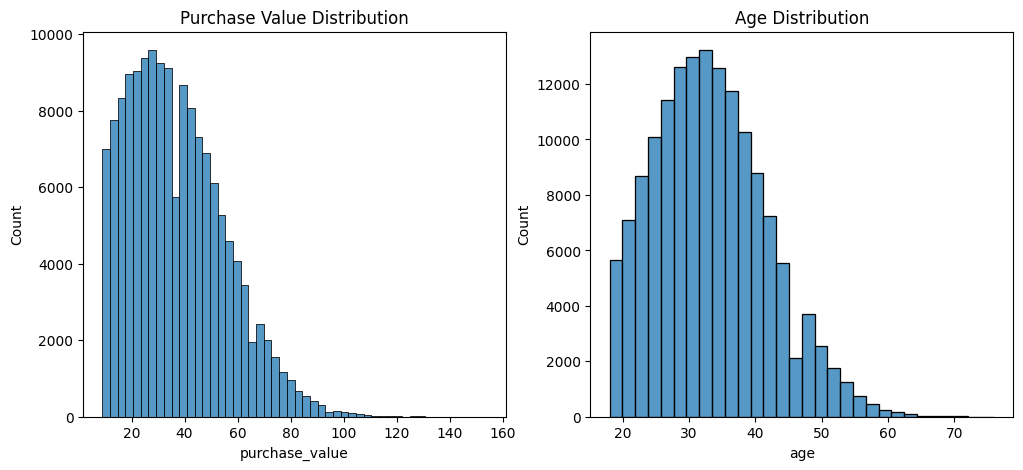

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['purchase_value'], bins=50, ax=axes[0])
axes[0].set_title('Purchase Value Distribution')
sns.histplot(df['age'], bins=30, ax=axes[1])
axes[1].set_title('Age Distribution')
plt.savefig('../reports/figures/fraud_univariate_analysis.png')
plt.show()

## Bivariate Analysis

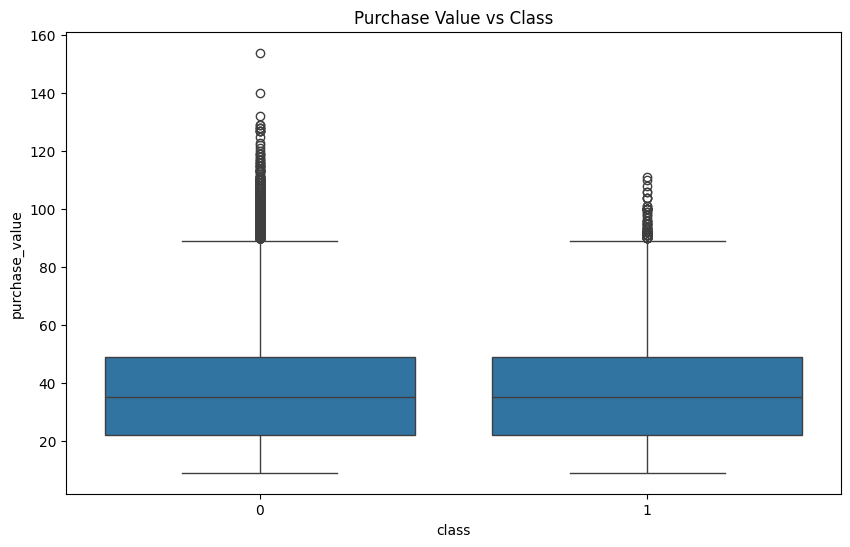

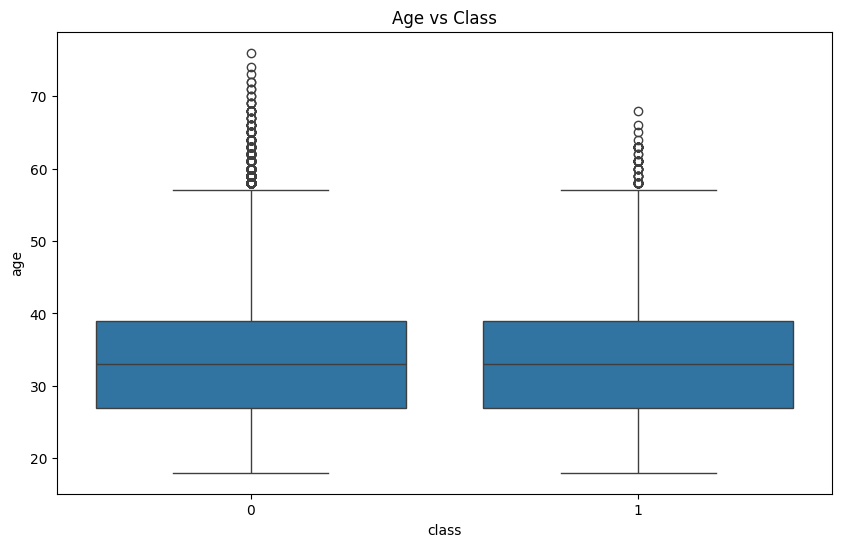

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='purchase_value', data=df)
plt.title('Purchase Value vs Class')
plt.savefig('../reports/figures/fraud_purchase_value_vs_class.png')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='age', data=df)
plt.title('Age vs Class')
plt.savefig('../reports/figures/fraud_age_vs_class.png')
plt.show()

## Fraud Patterns by Country

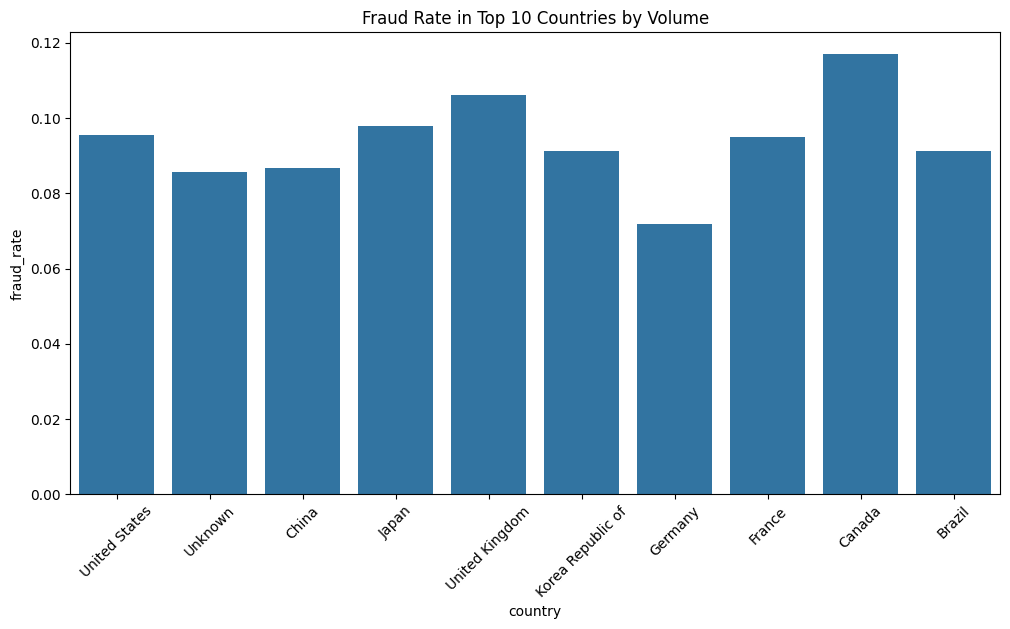

Top Countries by Fraud Count:
                   total_transactions  fraud_transactions  fraud_rate
country                                                              
United States                   58049                5551    0.095626
Unknown                         21966                1883    0.085723
China                           12038                1043    0.086642
Japan                            7306                 715    0.097865
United Kingdom                   4490                 477    0.106236
Korea Republic of                4162                 380    0.091302
Canada                           2975                 348    0.116975
France                           3161                 300    0.094907
Brazil                           2961                 270    0.091185
Germany                          3646                 262    0.071860


In [9]:
# Calculate fraud rate per country
country_fraud = df.groupby('country').agg({'class': ['count', 'sum']})
country_fraud.columns = ['total_transactions', 'fraud_transactions']
country_fraud['fraud_rate'] = country_fraud['fraud_transactions'] / country_fraud['total_transactions']

# Top countries by total transactions
top_countries = country_fraud.sort_values('total_transactions', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries.index, y=top_countries['fraud_rate'])
plt.title('Fraud Rate in Top 10 Countries by Volume')
plt.xticks(rotation=45)
plt.savefig('../reports/figures/fraud_rate_by_country.png')
plt.show()

print("Top Countries by Fraud Count:")
print(country_fraud.sort_values('fraud_transactions', ascending=False).head(10))